# Epidemics on networks

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import EoN
import numpy as np
from scipy.stats import kendalltau
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs

from src.utils import *

import warnings
warnings.filterwarnings('ignore')

## SIR model an a dense Erdos-Renyi graph


We use the [EoN](https://epidemicsonnetworks.readthedocs.io/en/latest/EoN.html) package to perform epidemic simulations on graphs. First, we need to generate the graph with the [NetworkX](https://networkx.org/) package.

In [2]:
# number of nodes
n = 20000

# expected average degree
d = 100

# generate an Erdos-Renyi random graph
G = nx.fast_gnp_random_graph(n, d/n)


we then set the parameters of the infectious disease together with the temporal resolution `dt` and the initial seeds, so the nodes that are infected at $t_0$.
> **Note**: in theory we could use only one infected individual, but since the simulation is stochastic, it may occur that that single individual recovers before infecting anyone else, thus immediately halting the epidemic. This can happen with some probability in the first steps even if $R_0>1$. To deal with this problem we may perform several simulations and look at the probability of having an outbreak of a given size, or adding more seeds, so that the probability that all recover before ppagating the infection goes to zero if $R_0 > 1$.

In [3]:
# rate of infection
β = 0.05

# recovery rate
μ = 1

# temporal resolution
dt = 0.3

# select the seeds
n_seeds = 5
r = np.random.choice(np.arange(n), n_seeds, replace = False)

# run the simulation
t, S, I, R = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, tmax = 200)

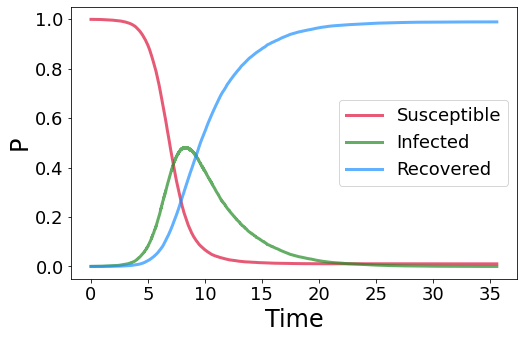

In [4]:
# PLOT

plt.figure(figsize = (8, 5))
plt.plot(t, S/n, color = 'crimson', label = 'Susceptible', linewidth = 3, alpha = 0.7)
plt.plot(t, I/n, color = 'forestgreen', label = 'Infected', linewidth = 3, alpha = 0.7)
plt.plot(t, R/n, color = 'dodgerblue', label = 'Recovered', linewidth = 3, alpha = 0.7)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('Time', fontsize = 24)
plt.ylabel('P', fontsize = 24)

plt.legend(fontsize = 18)
plt.show();

## Epidemic threshold

We now test the epidemic threshold on a configuration model and compare the empirical results with theory. We run the experiment for both a sparse and a dense graph to see the difference between these two regimes.

Under the naive mean field approximation, we saw that the critical $R_0$ at which the transition occurs is

$$
R_0 = \frac{\rho(A)\beta}{\mu},
$$

where $\rho(A)$ is the spectral radius of the graph adjacency matrix. For $R_0 > 1$ we exect a non-neglibible fraction of nodes to get infected at some point, while for $R_0 < 1$ we expect the epimic to die out. For a **dense** configuration model

$$
\rho(A) \approx \kappa = \frac{\langle \mathbf{d}^2 \rangle}{\langle \mathbf{d}\rangle}.
$$

where $\langle \cdot\rangle$ indicates the empirical average and $\mathbf{d}$ is the degree vector.

In [6]:
# set the number of nodes and the average degree
n, d = 100000, 100

# generate a heterogeneous degree sequence
θ = np.random.uniform(3, 12, n)**6
deg_sequence = θ/np.mean(θ)*d

# generate the graph and the adjacency matrix
G = nx.expected_degree_graph(deg_sequence)
A = nx.adjacency_matrix(G)

# we infect r nodes with a probability proportional to their degree
r = 20
r = np.random.choice(np.arange(n), r, p = deg_sequence/np.sum(deg_sequence))

# we try several values of β 
βv = np.linspace(0.001, 0.01, 15)

res = []

for i, β in enumerate(βv):
    # print progress bar
    print("[%-25s] %d%%" % ('='*(int((i+1)/len(βv)*25)-1) + '>', (i+1)/(len(βv))*100), end = '\r')

    # run the simulation    
    t, S, I, R = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, tmax = 500)

    # we save the fraction of people that have been "touched" by the epidemic
    res.append(1-S[-1]/n)

Now we repeat the analysis using a graph with a small average degree

In [52]:
# set the number of nodes and the average degree
n, d = 100000, 3

# generate a heterogeneous degree sequence
θ = np.random.uniform(3, 12, n)**6
deg_sequence = θ/np.mean(θ)*d

# generate the graph and the adjacency matrix
G = nx.expected_degree_graph(deg_sequence)
A_sparse = nx.adjacency_matrix(G)

# we infect r nodes with a probability proportional to their degree
r = 20
r = np.random.choice(np.arange(n), r, p = deg_sequence/np.sum(deg_sequence))

# we try several values of β 
βv_sparse = np.linspace(0.05, 0.18, 15)

res_sparse = []

for i, β in enumerate(βv_sparse):
    # print progress bar
    print("[%-25s] %d%%" % ('='*(int((i+1)/len(βv_sparse)*25)-1) + '>', (i+1)/(len(βv_sparse))*100), end = '\r')

    # run the simulation    
    t, S, I, R = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, tmax = 500)

    # we save the fraction of people that have been "touched" by the epidemic
    res_sparse.append(1-S[-1]/n)

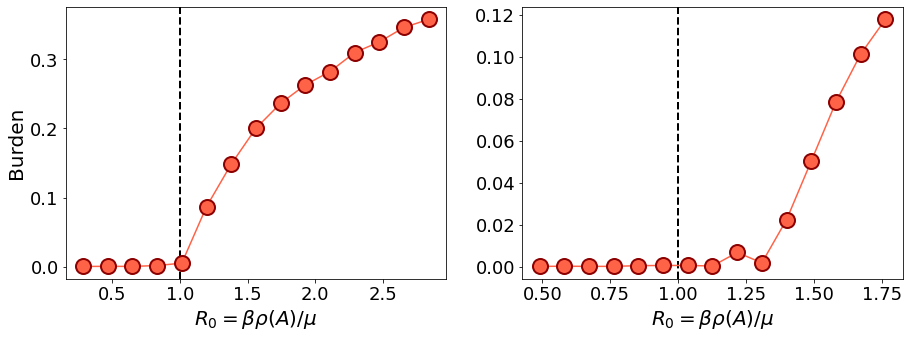

In [54]:
# PLOT
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ρA = SpectralRadius(A)
ax[0].plot(βv*ρA/μ, res, marker = 'o', color = 'tomato', markersize = 15, markeredgecolor = 'darkred', markeredgewidth = 2, zorder = 3)
ax[0].axvline(1, color = 'k', linewidth = 2, linestyle = '--')
ax[0].tick_params(axis = 'both', labelsize = 18)
ax[0].set_xlabel(r'$R_0 = \beta\rho(A)/\mu$', fontsize = 20)
ax[0].set_ylabel('Burden', fontsize = 20)

ρA = SpectralRadius(A_sparse)
ax[1].plot(βv_sparse*ρA/μ, res_sparse, marker = 'o', color = 'tomato', markersize = 15, markeredgecolor = 'darkred', markeredgewidth = 2, zorder = 3)
ax[1].axvline(1, color = 'k', linewidth = 2, linestyle = '--')
ax[1].tick_params(axis = 'both', labelsize = 18)
ax[1].set_xlabel(r'$R_0 = \beta\rho(A)/\mu$', fontsize = 20)

plt.savefig('Figures/R0.pdf', dpi = 400, bbox_inches = 'tight')
plt.show();

From this plot we can see that the prediction of naive mean field is accurate on the dense graph, but not on the sparse one. Let us now use the predicted $R_0$ according to the cavity method, that is accurate on sparse graphs as well

$$
R_0 = \frac{\beta(\rho(B)-1)}{\mu},
$$

where $B$ is the non-backtracking matrix.

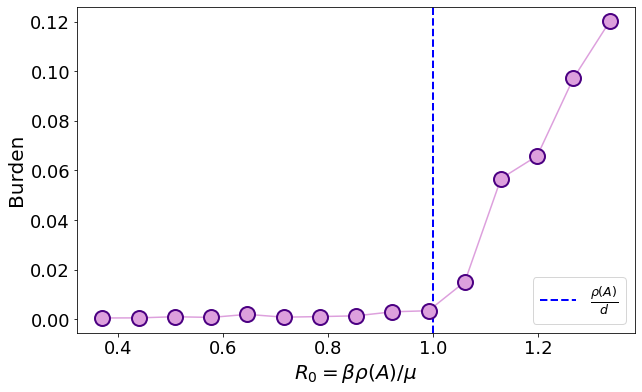

In [50]:
# PLOT
fig, ax = plt.subplots(figsize = (10, 6))

ρB = SpectralRadiusNB(A_sparse)
ax.plot(βv_sparse*(ρB-1)/μ, res_sparse, marker = 'o', color = 'plum', markersize = 15, markeredgecolor = 'indigo', markeredgewidth = 2, zorder = 3)
ax.axvline(1, color = 'blue', linewidth = 2, label = r'$\frac{\rho(A)}{d}$', linestyle = '--')
ax.legend(fontsize = 18, loc = 4)
ax.tick_params(axis = 'both', labelsize = 18)
ax.set_xlabel(r'$R_0 = \beta\rho(A)/\mu$', fontsize = 20)
ax.set_ylabel('Burden', fontsize = 20)

plt.savefig('Figures/R0_B.pdf', dpi = 400, bbox_inches = 'tight')

plt.show();

## Hitting time

We define the hitting time as the time at which a node gets infected. We show on a heterogeneous network that the hitting time correlates negatively with the degree, meaning that nodes with a large degree are the first ones to be hit and then they propagate the virus in the whole network, thus making the $R_0$ larger in a heterogeneous network for fixed $\beta, \mu, \langle d \rangle$.

In [3]:
n, d = 30000, 30

# generate a heterogeneous degree sequence
θ = np.random.uniform(3, 20, n)**6
deg_sequence = θ/np.mean(θ)*d

# generate the graph and the adjacency matrix
G = nx.expected_degree_graph(deg_sequence)
A = nx.adjacency_matrix(G)

r = np.random.choice(np.arange(n), 10, replace = False)

β = 0.05
μ = 0.05
dt = .1
# run the simulation    
res = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, return_full_data = True)

In [12]:
hitting_time, deg = [], []
d = A@np.ones(n)

for i in range(n):
    if len(res.node_history(i)[0]) > 1:
        hitting_time.append(res.node_history(i)[0][1])
        deg.append(d[i])

deg, hitting_time = np.array(deg), np.array(hitting_time)

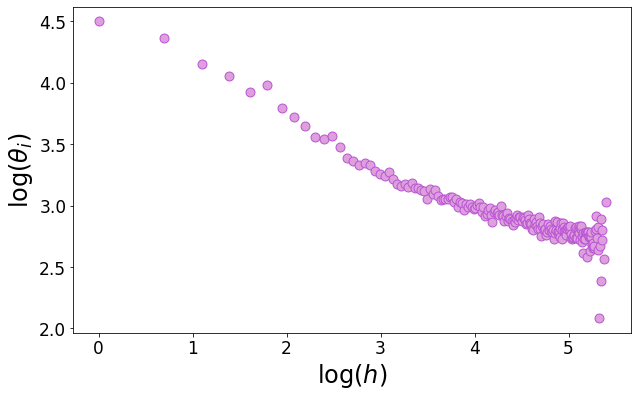

In [27]:
all_d = np.unique(deg)
x, y = np.log(all_d), [np.mean(np.log(hitting_time[deg == x])) for x in all_d]

plt.figure(figsize = (10,6))
plt.scatter(x, y, s = 80, edgecolor = 'mediumorchid', color = 'plum')
plt.xlabel(r'${\rm log}(h)$', fontsize = 24)
plt.xticks(fontsize = 17)
plt.ylabel(r'${\rm log}(\theta_i)$', fontsize = 24)
plt.yticks(fontsize = 17)
# plt.savefig('Figures/hitting_time.pdf', dpi = 400, bbox_inches = 'tight')

plt.show();

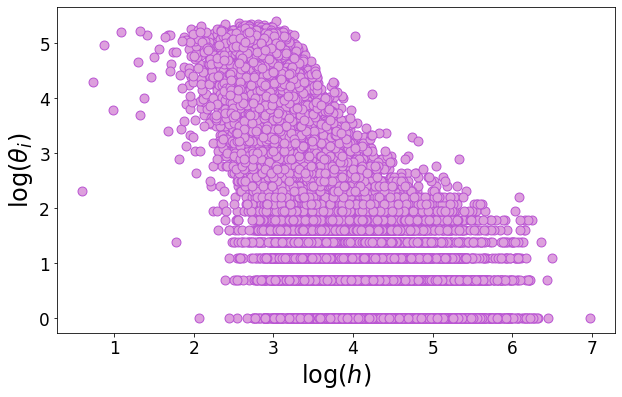

KendalltauResult(correlation=-0.563024278608012, pvalue=0.0)


In [28]:
idx = hitting_time > 0

plt.figure(figsize = (10,6))
plt.scatter(np.log(hitting_time[idx]), np.log(deg[idx]), s = 80, edgecolor = 'mediumorchid', color = 'plum')
plt.xlabel(r'${\rm log}(h)$', fontsize = 24)
plt.xticks(fontsize = 17)
plt.ylabel(r'${\rm log}(\theta_i)$', fontsize = 24)
plt.yticks(fontsize = 17)
plt.savefig('Figures/hitting_time.pdf', dpi = 400, bbox_inches = 'tight')

plt.show();

print(kendalltau(np.log(hitting_time[idx]), np.log(deg[idx])))

## Immunization


We now consider the outcome of immunization. Practically, a fraction o the population (25%) is vaccinated and cannot get infected. We saw that in this case, letting $\mathbf{s}$ be a Boolean vector so that $s_i = 0$ is $i$ is vaccinated, then the $R_0$ becomes (from the cavity method)

$$
R_0 = \frac{\beta}{\mu}\cdot\left(\frac{\mathbf{s}^T\mathbf{d}^2}{\mathbf{1}_n^T\mathbf{d}}-1\right).
$$

We compare three curves: no vaccination, random vaccination and targeted vaccination, in which the probability of being vaccinated is proportional to the node degree. Note that

In [12]:
# create the graph
n, d = 50000, 30
θ = np.random.uniform(3, 20, n)**6
deg_sequence = θ/np.mean(θ)*d
G = nx.expected_degree_graph(deg_sequence)
A = nx.adjacency_matrix(G)


dt = 0.05
μ = 3
βv = np.linspace(0.005, .25, 25)
vaccinated_fraction = 0.1

# these are the seeds
r = np.random.choice(np.arange(n), 15, replace = False, p = deg_sequence/np.sum(deg_sequence))


### No vaccination
res = []
for i, β in enumerate(βv):
    # print progress bar
    print("[%-25s] %d%%" % ('='*(int((i+1)/len(βv)*25)-1) + '>', (i+1)/(len(βv))*100), end = '\r')

    # run the simulation    
    t, S, I, R = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, tmax = 500)

    # we save the fraction of people that have been "touched" by the epidemic
    res.append(1-S[-1]/n)

### Random vaccination
vaccinated_rdn = np.random.choice(list(set(np.arange(n)) - set(r)), int(n*vaccinated_fraction), replace = False)
res_v_rdn = []

print('\n')

for i, β in enumerate(βv):
    # print progress bar
    print("[%-25s] %d%%" % ('='*(int((i+1)/len(βv)*25)-1) + '>', (i+1)/(len(βv))*100), end = '\r')

    # run the simulation    
    t, S, I, R = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, initial_recovereds = vaccinated_rdn, tmax = 500)

    # we save the fraction of people that have been "touched" by the epidemic
    res_v_rdn.append(1-S[-1]/n - vaccinated_fraction)


### Targeted vaccination
p = deg_sequence[~np.isin(np.arange(n), r)]
vaccinated_target = np.random.choice(list(set(np.arange(n)) - set(r)), int(n*vaccinated_fraction), replace = False, p = p/np.sum(p))
res_v_target = []

print('\n')

for i, β in enumerate(βv):
    # print progress bar
    print("[%-25s] %d%%" % ('='*(int((i+1)/len(βv)*25)-1) + '>', (i+1)/(len(βv))*100), end = '\r')

    # run the simulation    
    t, S, I, R = EoN.Gillespie_SIR(G, β*dt, μ*dt, initial_infecteds = r, initial_recovereds = vaccinated_target, tmax = 500)

    # we save the fraction of people that have been "touched" by the epidemic
    res_v_target.append(1-S[-1]/n - vaccinated_fraction)

[========================>] 100%

[========================>] 100%



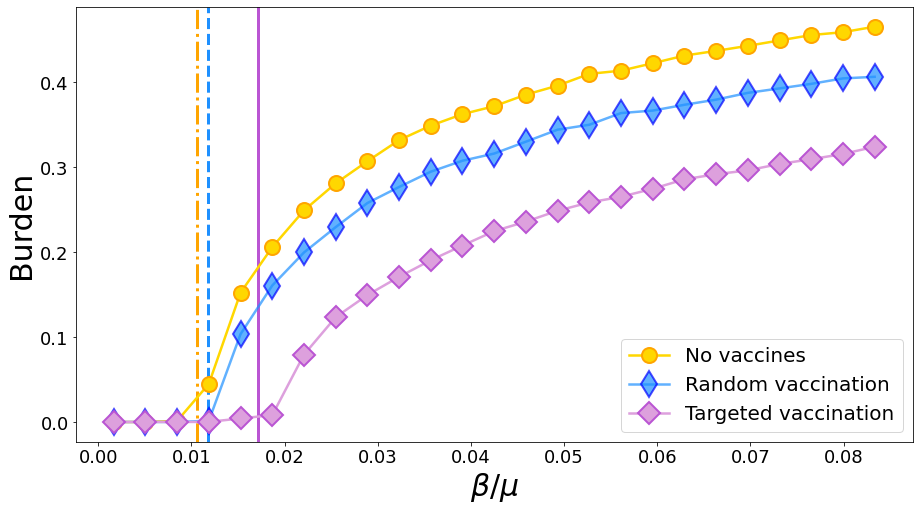

In [40]:
plt.figure(figsize = (15,8))
plt.plot(βv/μ, res, marker = 'o', markersize = 15, color = 'gold', markeredgecolor = 'orange', linewidth = 2.5, markeredgewidth = 2, label = 'No vaccines', zorder = 3)
ρ = deg_sequence**2@np.ones(n)/(deg_sequence@np.ones(n))
plt.axvline(1/(ρ-1), color = 'orange', linestyle = '-.', linewidth = 3)

plt.plot(βv/μ, res_v_rdn, marker = 'd', color = 'dodgerblue', markersize = 18, markeredgecolor = 'blue',  linewidth = 2.5, markeredgewidth = 2, label = 'Random vaccination', alpha = 0.7, zorder = 3)
idx = ~np.isin(np.arange(n), vaccinated_rdn)
ρ = deg_sequence[idx]**2@np.ones(sum(idx))/(deg_sequence@np.ones(n))
plt.axvline(1/(ρ-1), color = 'dodgerblue', linestyle = '--', linewidth = 3)

plt.plot(βv/μ, res_v_target, marker = 'D', color = 'plum', markeredgecolor = 'mediumorchid', markersize = 15,  linewidth = 2.5, markeredgewidth = 2, label = 'Targeted vaccination', zorder = 3)
idx = ~np.isin(np.arange(n), vaccinated_target)
ρ = (deg_sequence[idx]**2@np.ones(sum(idx)))/(deg_sequence@np.ones(n))
plt.axvline(1/(ρ-1), color = 'mediumorchid', linestyle = '-', linewidth = 3)


plt.xlabel(r'$\beta/\mu$', fontsize = 30)
plt.xticks(fontsize = 18)
plt.ylabel('Burden', fontsize = 30)
plt.yticks(fontsize = 18)

plt.legend(fontsize = 20)

# plt.savefig('Figures/vaccination.pdf', dpi = 400, bbox_inches = 'tight')

plt.show();

## Computing the spectrum of $B$

We compare the computation time of three approaches: one in which $B$ is built in a naive way from its definition; one in which the relation $B = Q^TT-M$ is used; finally one in which $B_{\rm p}$ is deployed to compute $\rho(B)$.

In [2]:
from time import time

# create a sparse Erdos-Renyi
n, d = 10000, 5
G = nx.fast_gnp_random_graph(n, d/n)
A = nx.adjacency_matrix(G)


In [3]:
# adjacency matrix

t0 = time()
# compute the leading eigenvalue
ρ, _  = eigsh(A.astype(float), k = 1, which = 'LM')
print(f'Spectral radius: {ρ[0]}')
print(f'Computation time: {time() - t0}')

Spectral radius: 6.227542335277015
Computation time: 0.2604939937591553


In [4]:
# naive implementation
t0 = time()

edges = [tuple(x) for x in np.array(A.nonzero()).T]
E = len(edges)

# find the indices of neighboring non-backtracking edges
idx1, idx2 = [], []

for i, e1 in enumerate(edges):
    for j, e2 in enumerate(edges):
        if e1[1] == e2[0]:
            if e1[0] != e2[1]:
                idx1.append(i)
                idx2.append(j)

# build the matrix
B = csr_matrix((np.ones(len(idx1)), (idx1, idx2)), shape = (E,E))

# compute the leading eigenvalue
ρ, _  = eigs(B, k = 1, which = 'LM')
print(f'Spectral radius: {ρ.real[0]}')
print(f'Computation time: {time() - t0}')

Spectral radius: 5.023631946925311
Computation time: 262.6648054122925


In [5]:
# B = Q^TT-M

t0 = time()

# create a mapping between edges and integers
Edge2Index = dict(zip(edges, np.arange(E)))

# build T
idx1 = [e[0] for e in edges]
idx2 = [Edge2Index[e] for e in edges]
T = csr_matrix((np.ones(E), (idx1, idx2)), shape = (n,E))

# build Q
idx1 = [e[1] for e in edges]
Q = csr_matrix((np.ones(E), (idx1, idx2)), shape = (n,E))

# build M
idx1 = [Edge2Index[e[::-1]] for e in edges]
M = csr_matrix((np.ones(E), (idx1, idx2)), shape = (E,E))

# build B
B = T.T@Q - M

# compute the leading eigenvalue
ρ, _  = eigs(B, k = 1, which = 'LM')
print(f'Spectral radius: {ρ.real[0]}')
print(f'Computation time: {time() - t0}')

Spectral radius: 5.023631946925306
Computation time: 0.32015323638916016


In [6]:
# Bp
t0 = time()

D = diags(A@np.ones(n))
Id = diags(np.ones(n))
Bp = bmat([[A, -Id], [D-Id, None]])

# compute the leading eigenvalue
ρ_naive, _  = eigs(Bp, k = 1, which = 'LM')
print(f'Spectral radius: {ρ.real[0]}')
print(f'Computation time: {time() - t0}')


Spectral radius: 5.023631946925306
Computation time: 0.08565306663513184
